## What is the True Normal Human Body Temperature?


#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
sns.set()

df = pd.read_csv('data/human_body_temperature.csv')
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


Before we do any statistical analysis, we'll explore the data visually.

In [154]:
df.temperature.describe()

count    130.000000
mean      98.249231
std        0.733183
min       96.300000
25%       97.800000
50%       98.300000
75%       98.700000
max      100.800000
Name: temperature, dtype: float64

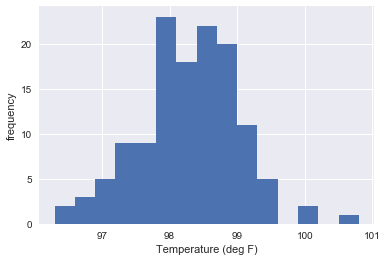

In [155]:
plt.hist(df.temperature, bins = 15)
plt.xlabel('Temperature (deg F)')
plt.ylabel('frequency')
plt.show()

The histogram shows a somewhat normal distribution, but we should be aware that changing the bin width has a significant effect on the shape of the data.  We should explore further. 

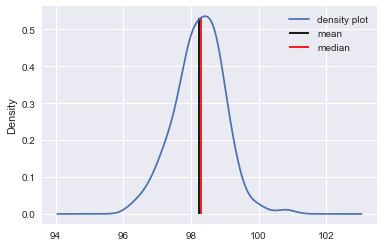

In [156]:
df['temperature'].plot(kind = 'density')
plt.vlines(df['temperature'].mean(), ymin = 0, ymax = .53)
plt.vlines(df['temperature'].median(), ymin = 0, ymax = .53, color = 'red')
plt.legend(('density plot', 'mean', 'median'))
plt.show()

In [157]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x) + 1) / n

    return x, y

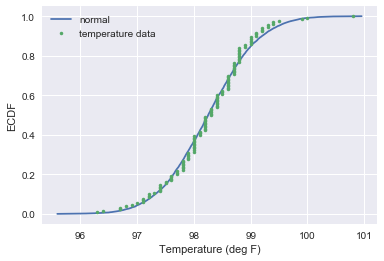

In [158]:
# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(np.mean(df.temperature),np.std(df.temperature),10000)
x_theor, y_theor = ecdf(samples)
temp_x, temp_y = ecdf(df['temperature'])

plt.plot(x_theor, y_theor)
plt.plot(temp_x, temp_y, marker = '.', linestyle = 'none')
plt.xlabel("Temperature (deg F)")
plt.ylabel('ECDF')
plt.legend(('normal', 'temperature data'))
plt.show()

### Q-Q Plot
A Q-Q plot provides a graphical view of how properties such as location, scale, and skewness are smiliar in two distributions.  For this exercise, we'll compare the temperature data to a typical normal distribution.  General outline of the code seen below was found at:  https://stackoverflow.com/questions/13865596/quantile-quantile-plot-using-scipy

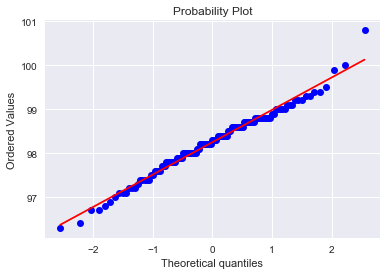

In [159]:
stats.probplot(df['temperature'], dist = 'norm', plot = pylab)
pylab.show()

We can see from the Q-Q plot that there appears to be some skewedness on both the left and right side of the distribution. 

### 1) Is the distribution of body temperatures normal?
The data does appear to be normal. There is skewedness on both the left and right, as well as a high concentration of values between the median and third quartile, so to be safe, we'll perform a test for normality.

Scipy has a function to test whether a sample differs from a normal distribution.

"The function tests the null hypothesis that a sample comes from a normal distribution. It is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality."
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.normaltest.html

In [160]:
k2, p = stats.normaltest(df['temperature'])
alpha = 1e-3
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: df['temperature'] comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.258748
The null hypothesis cannot be rejected


At the .05 level of significance, we fail to reject the null hypothesis.  We do not have evidence that the data does not come from a normal population.  Note that this is not the same as a  guarantee of normality. 

### 2) Is the sample size large? Are the observations independent?

In [161]:
print('Sample size: ', len(df.temperature))

Sample size:  130


The central limit theorem requires a sample size larger than 30 with independent sampling. Since we have 130 samples, and one person's body temperature has no effect on another, both conditions are satisfied.

## 3) Is the true population mean really 98.6 degrees F?
We will perform a 1-sample test for means.  For sample sizes larger than 30, it's best to use the z-statistic, but because the population standard deviation is unknown, we approximate it with our sample standard deviation.  This will give us the same test statistic for either test.  The only difference is  in calculating the p-value.

\begin{equation}t = \frac{(\bar{x} – μ)}{\frac{s}{\sqrt{n}}}\end{equation}


In [162]:
mean = np.mean(df.temperature)
std = np.std(df.temperature)
n = len(df.temperature)
test_statistic = (mean - 98.6) / (std / math.sqrt(n)) 
print('test statistic =',test_statistic)
print('z-test p-value =', stats.norm.cdf(test_statistic)*2)

test statistic = -5.475925202078116
z-test p-value = 4.35231516588e-08


Our p-value suggests that obtaining a mean equal to that of our sample is very unlikely assuming that 98.6 is the true population mean.  We reject the null hypothesis and state that the true population mean is not 98.6 degrees F.

For comparison, we'll compute the p-value using a t-test.

In [163]:
print('t-test p-value = ',stats.t.cdf(x = test_statistic, df =len(df['temperature']) - 1)*2)

t-test p-value =  2.18874646241e-07


In [164]:
stats.ttest_1samp(df['temperature'], 98.6)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

We see a similarily low p-value using a t-test.  It's not as low because the t-distribution carries more weight in the tails, but it is still stastically significant.

## 4) Draw a small sample of size 10 from the data and repeat both tests.

In [165]:
small_sample = np.random.choice(df.temperature, size = 10)

mean_ss = np.mean(small_sample)
std_ss = np.std(small_sample)
n_ss = len(small_sample)
test_statistic_ss = (mean_ss - 98.6) / (std_ss / math.sqrt(n_ss)) 

print('test statistic =',test_statistic_ss)
print('z-test p-value =', stats.norm.cdf(test_statistic_ss)*2)
print('t-test p-value =', stats.t.cdf(x = test_statistic_ss, df =len(small_sample) - 1)*2)

test statistic = -0.807710043754
z-test p-value = 0.419257520364
t-test p-value = 0.440082490608


Changing the sample size indicates the sensitivity of the sample size when using a t-test.  As n increases, the t distribution is approximately normal.

## 5) At what temperature should we consider someone's temperature to be "abnormal"?

In [166]:
se = s / math.sqrt(n)

In [167]:
low = np.mean(df.temperature) - 1.96*se
high = np.mean(df.temperature) + 1.96*se
print('We are 95% confident that the true mean body temperature is between', low, 'and', high, 'degrees Fahrenheit.')

We are 95% confident that the true mean body temperature is between 98.12367980442819 and 98.37478173403336 degrees Fahrenheit.


We could consider anything outside of this range to be abnormal for a mean temperature.  95% of the samples we take will have a mean within this range.

## 6) Is there a significant difference between males and females in normal temperature?

In [168]:
male = df.loc[df.gender == 'M']
female = df.loc[df.gender == 'F']

mean_male = np.mean(male.temperature)
var_male = np.var(male.temperature)
n_male = len(male.temperature)

mean_female = np.mean(female.temperature)
var_female = np.var(female.temperature)
n_female = len(female.temperature)

In [169]:
test_stat_diff = (mean_male - mean_female) / math.sqrt((var_male/n_male) + (var_female/n_female))
print('test statistic =', test_stat_diff)
print('z-test p-value =', stats.norm.cdf(test_stat_diff)*2)

test statistic = -2.3032202891940123
z-test p-value = 0.0212664518301


At the .05 level of significance, we reject the null hyptothesis and state that there is a difference between the mean temperature of males vs. females.

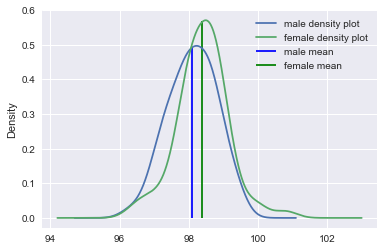

In [170]:
male.temperature.plot(kind = 'density')
female.temperature.plot(kind = 'density')
plt.vlines(male.temperature.mean(), ymin = 0, ymax = .49, color = 'blue')
plt.vlines(female.temperature.mean(), ymin = 0, ymax = .57, color = 'green')
plt.legend(('male density plot', 'female density plot', 'male mean', 'female mean'))
plt.show()

## Conclusion

From the analysis, we can conclude our understanding of typical body temperature is incomplete, assuming that the population follows a normal distribution.  While body temperatures are almost certainly not 98.6 degrees F on average, it is worth investigating what other factors contribute to body temperature.  Furthermore, it's appropriate to state that the mean temperature differs between genders.  